## NLP for Supervised Learning

### Read in cappuccino cup review data

In [1]:
import nltk
import pandas as pd

In [2]:
data = pd.read_csv('coffee.csv')
data.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted to love this. I was even prepared for...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups were excellent. T...
2,AJ3L5J7GN09SV,2,I bought the Grove Square hazelnut cappuccino ...
3,A3CZD34ZTUJME7,1,"I love my Keurig, and I love most of the Keuri..."
4,AWKN396SHAQGP,1,It's a powdered drink. No filter in k-cup.<br ...


### Exploratory data analysis

In [3]:
# There are 542 reviews in the dataset
len(data)

542

In [4]:
# While most reviewers leave a 5 star review, there are also a good portion leaving 1 star reviews
data.stars.value_counts(normalize=True)  # normalize is just dividing by something

5    0.568266
1    0.177122
4    0.119926
2    0.083026
3    0.051661
Name: stars, dtype: float64

In [5]:
data.stars.value_counts()

5    308
1     96
4     65
2     45
3     28
Name: stars, dtype: int64

In [6]:
import numpy as np

# Remove 3 star reviews
data = data[data.stars!=3]   # because it is neutral and possess no information

# Set 4/5 star reviews to positive, the rest to negative
data['sentiment'] = np.where(data['stars'] >= 4, 'positive', 'negative')   # saying 4 and 5 stars are positive 
                                                                           # and 1 and 2 stars are negative

# Include only the sentiment and reviews columns
data = data[['sentiment', 'reviews']]
data.head()

,sentiment,reviews
0,negative,I wanted to love this. I was even prepared for...
1,positive,Grove Square Cappuccino Cups were excellent. T...
2,negative,I bought the Grove Square hazelnut cappuccino ...
3,negative,"I love my Keurig, and I love most of the Keuri..."
4,negative,It's a powdered drink. No filter in k-cup.<br ...


In [7]:
# Check the length of the new dataset
len(data)

514

In [8]:
# Note that the dataset has mostly positive reviews
data.sentiment.value_counts(normalize=True)

positive    0.725681
negative    0.274319
Name: sentiment, dtype: float64

### Preprocess the text

In [9]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

data['reviews'] = data.reviews.map(alphanumeric).map(punc_lower)
data.head()

,sentiment,reviews
0,negative,i wanted to love this i was even prepared for...
1,positive,grove square cappuccino cups were excellent t...
2,negative,i bought the grove square hazelnut cappuccino ...
3,negative,i love my keurig and i love most of the keuri...
4,negative,it s a powdered drink no filter in k cup br ...


### Prepare data for modeling

In [10]:
# Split the data into X and y data sets
X = data.reviews
y = data.sentiment

In [11]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,able,abomination,absolute,absolutely,acceptable,accident,actual,actually,add,added,...,ya,year,years,yes,yessiree,yesterday,york,yuck,yum,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,able,able cappuccino,able drink,able finish,able longer,able make,able return,able switch,abomination,abomination bet,...,yummy gas,yummy great,yummy kuerig,yummy perfect,yummy price,yummy run,yummy strong,yummy suitable,yummy treat,yummy won
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X_test_cv2

<155x7792 sparse matrix of type '<class 'numpy.int64'>'
	with 3676 stored elements in Compressed Sparse Row format>

### Try classifying using Logistic Regression

In [14]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [15]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [45]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    fig, ax = plt.subplots()
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg)*1.0 / (true_pos + true_neg + false_pos + false_neg),3)
    print('Accuracy is: {}'.format(accuracy))
    precision = round((true_pos)*1.0 / (true_pos + false_pos),3)
    print('Precision is: {}'.format(precision))
    recall = round((true_pos)*1.0 / (true_pos + false_neg),3)
    print('Recall is: {}'.format(recall))
    f1 = round(2 * (precision * recall)*1.0 / (precision + recall),3)
    print('f1 is: {}'.format(f1))

    cm_results = [accuracy, precision, recall, f1]
    
    # Prevent Heatmap Cut-Off Issue
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return cm_results

Accuracy is: 0.865
Precision is: 0.9
Recall is: 0.923
f1 is: 0.911


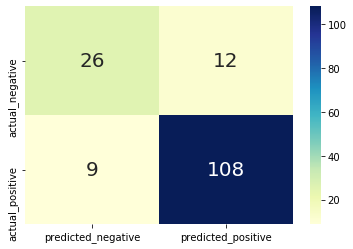

In [46]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

Accuracy is: 0.877
Precision is: 0.889
Recall is: 0.957
f1 is: 0.922


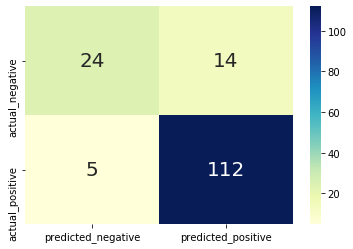

In [47]:
# The heat map for the second logistic regression model using 2-grams
cm2 = conf_matrix(y_test, y_pred_cv2)

In [20]:
# Compile all of the error metrics into a dataframe for comparison

# Using 2-grams provides a very very small increase 

results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']

results

,LogReg1,LogReg2
Accuracy,0.865,0.877
Precision,0.900,0.889
Recall,0.923,0.957
F1 Score,0.911,0.922


Comparing the two models, the first model has better precision, while the second model has better accuracy and recall.

In [ ]:
# Now we have a model that can make predictions of whether or not a review is positive or not

### Try classifying using Naive Bayes

In [41]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [42]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

Accuracy is: 0.884
Precision is: 0.909
Recall is: 0.94
f1 is: 0.924


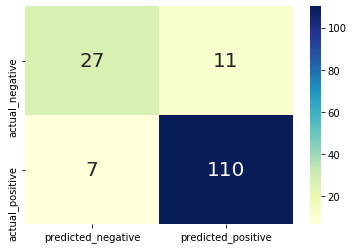

In [48]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

Accuracy is: 0.761
Precision is: 0.76
Recall is: 1.0
f1 is: 0.864


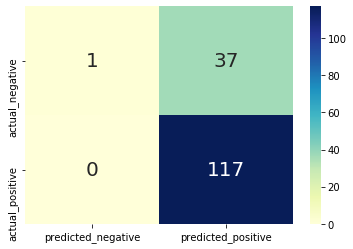

In [49]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [55]:
cm3

[0.884, 0.909, 0.94, 0.924]

In [56]:
cm4

[0.761, 0.76, 1.0, 0.864]

In [54]:
results_nb

,NB1,NB2
Accuracy,0.884,0.761
Precision,0.909,0.760
Recall,0.940,1.000
F1 Score,0.924,0.864


In [25]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)   # axis = 1 appends it as a column
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.865,0.877,0.884,0.761
Precision,0.900,0.889,0.909,0.760
Recall,0.923,0.957,0.940,1.000
F1 Score,0.911,0.922,0.924,0.864


The first Naive Bayes model outperforms both Logistic Regression models.

### Try using TF-IDF instead of Count Vectorizer

In [26]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

Accuracy is: 0.845
Precision is: 0.83
Recall is: 1.0
f1 is: 0.907


C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


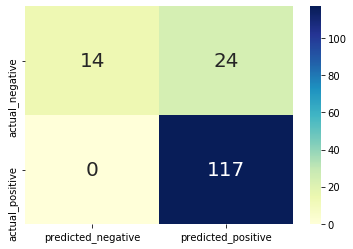

In [50]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)

y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)   # good name sense

cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

Accuracy is: 0.755
Precision is: 0.755
Recall is: 1.0
f1 is: 0.86


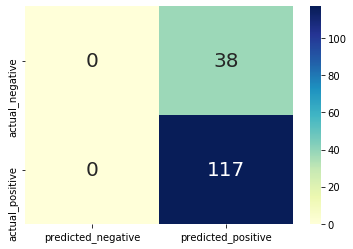

In [51]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

Accuracy is: 0.781
Precision is: 0.775
Recall is: 1.0
f1 is: 0.873


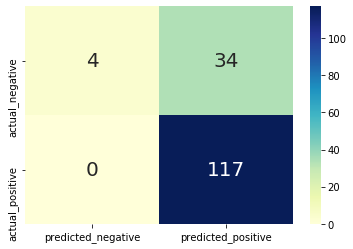

In [52]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

Accuracy is: 0.761
Precision is: 0.76
Recall is: 1.0
f1 is: 0.864


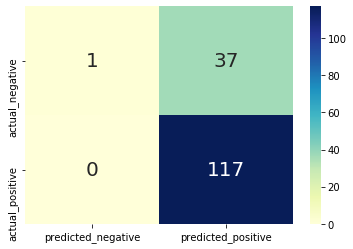

In [53]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [31]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

# We compare based on F1. F1 is pretty good to compare between modesl
# However when you want to present to business, show them the best one you have
# Then explain in terms of precision and recall

,LogReg1,LogReg2,NB1,NB2,LR1-TFIDF,LR2-TFIDF,NB1-TFIDF,NB2-TFIDF
Accuracy,0.865,0.877,0.884,0.761,0.845,0.755,0.781,0.761
Precision,0.900,0.889,0.909,0.760,0.830,0.755,0.775,0.760
Recall,0.923,0.957,0.940,1.000,1.000,1.000,1.000,1.000
F1 Score,0.911,0.922,0.924,0.864,0.907,0.860,0.873,0.864


It looks like using TF-IDF, we were able to improve the recall, but the accuracy and precision of the first Naive Bayes model still outperforms the other models.

Overall, the first Naive Bayes model (using unigrams and counts) seems to best classify positive and negative cappuccino cup reviews.

In [32]:
def to_roman(num):
    values = [
        1000, 900, 500, 400,
        100, 90, 50, 40,
        10, 9, 5, 4,
        1
    ]
    symbols = [
        "M", "CM", "D", "CD",
        "C", "XC", "L", "XL",
        "X", "IX", "V", "IV",
        "I"
    ]
    roman = ''
    i = 0
    while num > 0:
        for _ in range(num // values[i]):
            roman += symbols[i]
            num -= values[i]
        i += 1
    return roman


In [33]:
to_roman(123)

'CXXIII'